# Reinforcement learning with spiking neural networks

In [1]:
# @title Install prerequisites
#!pip3 install matplotlib gym --quiet
#!pip3 install git+https://github.com/norse/norse --quiet
#!pip3 install git+https://github.com/ncskth/norse-rl --quiet

%matplotlib inline

In [10]:
# @title Simulation setup
import gym
import matplotlib
import matplotlib.pyplot as plt
import torch
import norse.torch as norse
import IPython.display as display
import norse_rl # Init environment

def draw_network(ax, layer_sizes, weights):
    # Thanks to https://stackoverflow.com/a/67289898/999865
    top = .9
    bottom = .1
    left = .2
    right = .9
    layer_sizes = [len(x) for x in layer_sizes]
    v_spacing = 1 / max(layer_sizes)
    h_spacing = 1 / len(layer_sizes)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.

        for m in range(layer_size):
            center = (n * h_spacing + left, layer_top - m * v_spacing)
            radius = v_spacing / 4.
            circle = plt.Circle(center, radius, color='w', ec='k', zorder=4)
            ax.add_artist(circle)

        # Edges
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a):
                for o in range(layer_size_b):
                    weight = weights[n][o][m]
                    width = abs(weight) * 10 # Scale so it looks bigger
                    color = 'b' if weight < 0 else 'r'
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                                      c=color, lw=width)
                    ax.add_artist(line)
                    
def draw_network_update(ax, spikes):
    is_circle = lambda c: isinstance(c, matplotlib.patches.Circle)
    artists = list(filter(is_circle, ax.artists))
    index = 0
    for layer in spikes:
        for neuron in layer:
            color = 'b' if neuron else 'w'
            artists[index].set_facecolor(color)
            index += 1
                    
def ask_network(model, observation, state=None):
    observation = torch.tensor(observation, dtype=torch.float32)
    action, state = model(observation, state)
    return action.detach().numpy(), state

def weights_from_network(model):
    weights = []
    children = list(model.children())
    for l in children:
        if isinstance(l, torch.nn.Linear):
            weights.append(l.weight)
    assert len(weights) > 0, "We require at least one linear layer"
    assert len(weights) <= len(children) // 2, "We require at least every second layer to be a linear layer"
    return weights

def simulate(model):
    # Initialize environment and network
    observation = env.reset()
    state = None
    
    # Setup spike activity hooks
    activities = []
    def forward_state_hook(mod, inp, out):
        activities.append(out[0].detach())
    try:
        model.remove_forward_state_hooks()
        model.forward_state_hooks.clear()
        model.register_forward_state_hooks(forward_state_hook)
    except:
        pass # Ignore if model already has registered hooks
    
    # Initialize plotting
    # Thanks to https://matplotlib.org/stable/tutorials/advanced/blitting.html
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
    ax1.axis('off')
    ax2.axis('off')
    # Show the plot to start caching
    plt.show(block=False)
    bg = f.canvas.copy_from_bbox(f.bbox)
    # Draw initial background
    img = ax1.imshow(env.render(mode='rgb_array'), animated=True) # only call this once
    ax1.draw_artist(img)
    action, state = ask_network(model, observation, state)
    draw_network(ax2, activities, weights_from_network(model))
    
    # Loop until environment is done or user quits
    is_done = False
    try:
        while not is_done:
            #f.canvas.restore_region(bg)
            display.clear_output(wait=True)

            activities.clear()
            action, state = ask_network(model, observation, state)
            observation, _, is_done, _ = env.step(action)
            
            # Set visual changes
            img.set_data(env.render(mode='rgb_array')) # just update the data
            draw_network_update(ax2, activities)
            
            # Render graphics
            f.canvas.blit(f.bbox)
            f.canvas.flush_events()
            display.display(f)
            print(env.state)
    except KeyboardInterrupt:
        pass
    

## Setup environment
env = gym.make("Gridworld-v0")

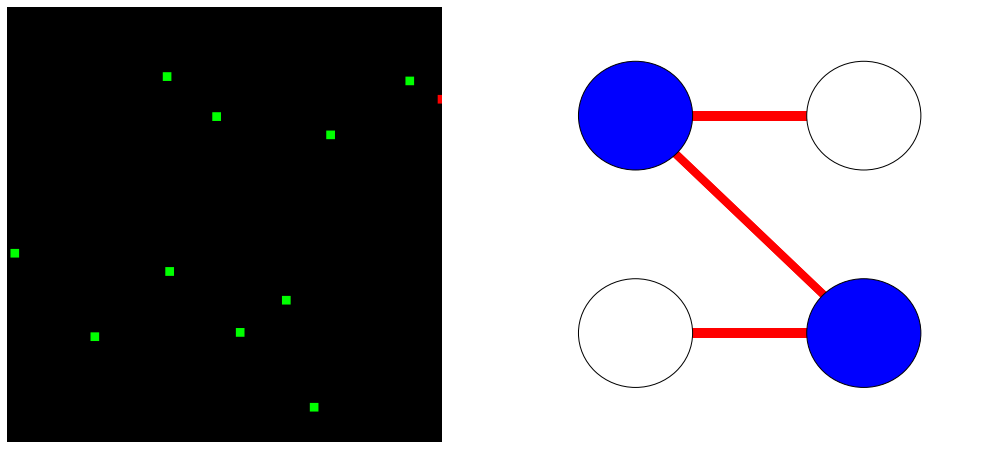

[500.        106.5916514   0.       ]


In [11]:
linear = torch.nn.Linear(2, 2, bias=False)
#linear_weight
linear.weight = torch.nn.Parameter(torch.tensor([[1, 0], [0.8, 1.]]))
model = norse.SequentialState(
    norse.LIFCell(),
    linear,
    norse.LIFCell()
)

simulate(model)